# Hopfield Networks in Action

In this project we will see how to implement hopfield networks to remember patterns.

A Hopfield net is a recurrent neural network having synaptic connection pattern such that there is an underlying Lyapunov function for the activity dynamics. Started in any initial state, the state of the system evolves to a final state that is a (local) minimum of the Lyapunov function.

There are two popular forms of the model:
- Binary neurons with discrete time, updated one at a time
- Graded neurons with continuous time

We will only be looking at Binary neurons with discrete time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    from tqdm import trange
except ModuleNotFoundError:
    %pip install -qq tqdm
    from tqdm import trange
try:
    from skimage.transform import resize
except ModuleNotFoundError:
    %pip install -qq scikit-image
    from skimage.transform import resize
import scipy.ndimage
from dataclasses import dataclass
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

url = 'https://raw.githubusercontent.com/probml/probml-data/main/data/binaryImages.csv'
df = pd.read_csv(url)
patterns = 2*df.to_numpy()[:, 1:]-1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00


In [ ]:
@dataclass
class Patterns:

  patterns: np.ndarray
  nimages: int

  @property
  def width(self):
    return int(self.patterns.shape[1]/self.nimages)

  @property
  def height(self):
    return self.patterns.shape[0]

  @property
  def shape(self):
    return self.patterns.shape

  def __getitem__(self, x):
    return self.patterns[x]

  def __setitem__(self, x, val):
    self.patterns[x] = val

  def copy(self):
    return Patterns(self.patterns.copy(), self.nimages)

def occlude_patterns(patterns, occlusion_rate=0.2, occlusion_area="left-half"):
    """
    Occludes the patterns by masking a fraction of pixels.

    Args:
        patterns (Patterns): An object containing the image patterns.
        occlusion_rate (float): The fraction of pixels to be occluded (0 to 1).

    Returns:
        np.ndarray: A new array of patterns with occluded pixels.
    """
    # Create a copy of the original patterns to modify
    patterns_occluded = patterns.copy()

    width = patterns.width
    height = patterns.height

    # Loop through each image in the patterns
    for i in range(patterns.nimages):
        # Determine the range of pixels to occlude based on the occlusion rate
        # Flip the selected pixels to a specific value (e.g., 1)
        # pass  # TODO: Implement the occlusion logic
        # Occlusion logic depending on the chosen area
        if occlusion_area == "left-half":
            # Mask the left half
            patterns_occluded.patterns[:, i*width:i*width + int(width * occlusion_rate)] = -1

        elif occlusion_area == "right-half":
            # Mask the right half
            patterns_occluded.patterns[:, i*width + int(width * (1 - occlusion_rate)):i*width + width] = -1

        elif occlusion_area == "top-half":
            # Mask the top half
            patterns_occluded.patterns[:int(height * occlusion_rate), i*width:i*width + width] = -1

        elif occlusion_area == "bottom-half":
            # Mask the bottom half
            patterns_occluded.patterns[int(height * (1 - occlusion_rate)):, i*width:i*width + width] = -1

    return patterns_occluded

def add_gaussian_noise(self, mean=0, std=0.1):
    """
    Adds Gaussian noise to the patterns based on a specified mean and standard deviation.

    Args:
        mean (float): The mean of the Gaussian noise.
        std (float): The standard deviation of the Gaussian noise.

    Returns:
        np.ndarray: A new array of patterns with Gaussian noise added.
    """
    # Create a copy of the original patterns to add noise to
    noisy_patterns = self.copy()

    # TODO: Iterate through the pattern images.
    # Generate Gaussian noise based on the mean and standard deviation
    # Add the generated noise to the patterns.

    # Loop through each pattern and add Gaussian noise
    noise = np.random.normal(mean, std, noisy_patterns.patterns.shape)

    # Add noise and clip to stay within [-1, 1] range
    noisy_patterns.patterns += noise
    noisy_patterns.patterns = np.clip(noisy_patterns.patterns, -1, 1)

    return noisy_patterns

def add_salt_and_pepper_noise(self, noise_rate=0.1):
    """
    Adds salt-and-pepper noise to the patterns at a specified noise rate.

    Args:
        noise_rate (float): The fraction of pixels to be set to salt or pepper (0 to 1).

    Returns:
        np.ndarray: A new array of patterns with salt-and-pepper noise added.
    """
    # Create a copy to add noise to
    noisy_patterns = self.copy()

    # TODO: Iterate through the pattern images.
    # Generate salt and pepper noise and modify the input pattern accordingly

    # Loop through each image and apply salt-and-pepper noise
    for i in range(noisy_patterns.nimages):
        # Extract the pattern for the current image
        current_image = noisy_patterns.patterns[:, i*noisy_patterns.width:(i+1)*noisy_patterns.width]

        total_pixels = current_image.size
        num_noisy_pixels = int(total_pixels * noise_rate)

        # Randomly choose pixel indices for salt (1) and pepper (-1)
        salt_indices = np.random.choice(total_pixels, num_noisy_pixels // 2, replace=False)
        pepper_indices = np.random.choice(total_pixels, num_noisy_pixels // 2, replace=False)

        # Flatten the image for indexing
        flattened_image = current_image.ravel()

        # Set salt and pepper values
        flattened_image[salt_indices] = 1
        flattened_image[pepper_indices] = -1

        # Reshape the image back and store it
        noisy_patterns.patterns[:, i*noisy_patterns.width:(i+1)*noisy_patterns.width] = flattened_image.reshape(current_image.shape)

    return noisy_patterns

def convert_patterns_to_vectors(patterns):
  new_shape = patterns.width*patterns.height
  vectors = np.zeros((patterns.nimages, new_shape))
  for i in range(patterns.nimages):
    img = patterns.patterns[:, i*patterns.width:(i+1)*patterns.width]
    vectors[i] = img.reshape((new_shape, ))
  new_patterns = Patterns(vectors, patterns.nimages)
  new_patterns.og_width =  patterns.width
  new_patterns.og_height =  patterns.height
  return new_patterns

def convert_vectors_to_patterns(vectors):
  new_shape = vectors.og_width*vectors.nimages
  patterns = np.zeros((vectors.og_height, new_shape))
  for i in range(vectors.nimages):
    img = vectors[i, :]
    patterns[:, i*vectors.og_width:(i+1)*vectors.og_width] = img.reshape(
        (vectors.og_height, vectors.og_width))
  return Patterns(patterns, vectors.nimages)

def plt_patterns(patterns, ndisplay=None, figsize=30, name=None):

  assert patterns.nimages >= ndisplay, "number of images in the datset cannot \
  be less than number of images to be displayed"

  if not ndisplay:
    ndisplay=self.nimages
  fig, axs = plt.subplots(1, ndisplay, figsize=(figsize, figsize*ndisplay))
  fig.suptitle(f'{name}', fontsize=16, y=0.55)
  for i in range(ndisplay):
    axs[i].imshow(patterns[:, i*patterns.width:(i+1)*patterns.width],
                  cmap="Greys")
  pml.savefig(f'{name}.pdf')
  plt.show()



## **Implementing a Hopfield Network**

In this project, we will implement a Hopfield network and test its ability to retrieve stored patterns using a corrupted input.

#### **1. Training the Network (Memorizing Patterns)**

We will implement the training step of a Hopfield network by using the following **rule**. This rule is defined as:

$$
W = \frac{1}{N} \sum_{i=1}^{N} x_i x_i^T
$$

Where:
- $N$ is the number of patterns,
- $x_i$ is a pattern to be memorized.

We will implement this recall process in the `fit` function. Make sure to set the diagonal of the weight matrix $W$ to zero to prevent self-feedback (i.e., a neuron doesn't influence itself).

#### **2. Pattern Completion (Recall)**

Given a partially occluded or corrupted input pattern, the network should iteratively update the state of each neuron using the update rule:

$$
x_{t+1} = \text{sgn}(W x_t)
$$

Where:
- $x_t$ is the state of the network at iteration $t$,
- $W$ is the weight matrix learned during training.
- The `sgn` function, short for **sign function**, is a mathematical function that determines the sign of a number. It returns:

  - $+1$ if the input is positive,
  - $-1$ if the input is negative,
  - $0$ if the input is zero (although in Hopfield networks, this is usually treated as either $+1$ or $-1$).

We will implement this recall process in the `recall` function. The network will use this iterative rule to complete the corrupted pattern and retrieve the closest stored pattern. For a correct implementation `steps` should be 2 or 3 for recall.


### **Note: Network Capacity**

Hopfield proved that, for random patterns, the network capacity is approximately 0.14 $N$. This means that the network can store up to 14% of the total number of neurons as stable patterns. Beyond this, the patterns may start to collide and the network may fail to recall the correct patterns.


In [ ]:
class HopfieldNetwork(object):

    def fit(self, patterns, ntrained=3):
        """
        Train the Hopfield network using rule defined above.

        Args:
        patterns (Patterns): The patterns to store in the network.
        ntrained (int): Patterns for ntrained images to store (default is 3).
        """
        # Get pattern dimensions from the first pattern
        self.og_width = patterns.og_width
        self.og_height = patterns.og_height

        # Initialize the weight matrix with zeros
        self.W = np.zeros((patterns.shape[1], patterns.shape[1]))

        # Train the network using Hebbian learning
        for i in range(ntrained):
            pattern = patterns[i].reshape(-1, 1)  # Reshape the pattern into a column vector
            self.W += np.dot(pattern, pattern.T)  # Outer product and sum

        # Set diagonal to 0 to prevent self-feedback
        np.fill_diagonal(self.W, 0)

        # Normalize by the number of patterns
        self.W /= ntrained

    def recall(self, patterns, steps=2):
        """
        Recall a pattern using the Hopfield network.

        Args:
        patterns (Patterns): The input patterns object to recall.
        steps (int): Number of update steps to perform (default is 2).

        Returns:
        Patterns: The recalled patterns (as a Patterns object).
        """
        # Create a copy to update states
        recalled_patterns = patterns.copy()

        # Perform recall for the specified number of steps
        for _ in range(steps):
            for i in range(recalled_patterns.nimages):
                # Update the state of each pattern using the weight matrix
                recalled_patterns[i] = np.sign(np.dot(self.W, recalled_patterns[i]))

        # Restore original width and height for the recalled patterns
        recalled_patterns.og_width = self.og_width
        recalled_patterns.og_height = self.og_height

        return recalled_patterns

## Running Test Cells

After completing the previous steps of our project, we will need to run the following three code cells to test the performance of our Hopfield network under different conditions. Each cell corresponds to a specific type of noise added to the patterns and demonstrates how well the network can recover the original patterns.


/usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


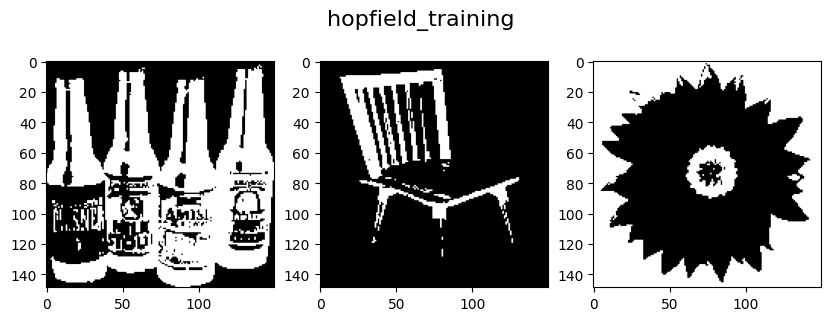

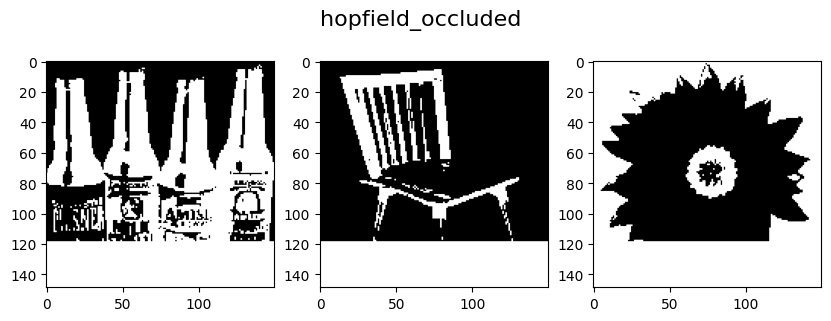

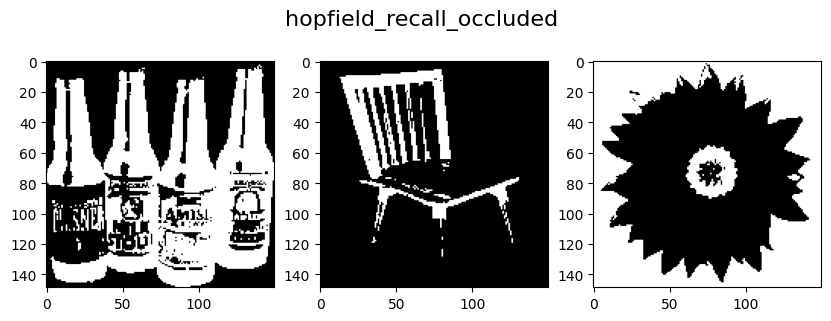

In [ ]:
#Occlude Patterns
# Create a Patterns object with the original patterns
pat = Patterns(patterns, 7)

ntrained = 3  # Number of patterns to display

# Display original patterns
plt_patterns(pat, ntrained, 10, name="hopfield_training")

# Convert original patterns to vectors
pattern_vectors = convert_patterns_to_vectors(pat)

# 1. Occlude Patterns
occluded_patterns = occlude_patterns(pat, occlusion_area="bottom-half")
occluded_patterns_vectors = convert_patterns_to_vectors(occluded_patterns)
plt_patterns(occluded_patterns, ntrained, 10, 'hopfield_occluded')

# Fit the Hopfield Network with original patterns
net = HopfieldNetwork()
net.fit(pattern_vectors, ntrained)

# Recall from occluded patterns
pattern_recovered_occluded = net.recall(occluded_patterns_vectors)
pattern_rec_occluded = convert_vectors_to_patterns(pattern_recovered_occluded)
plt_patterns(pattern_rec_occluded, ntrained, 10, 'hopfield_recall_occluded')


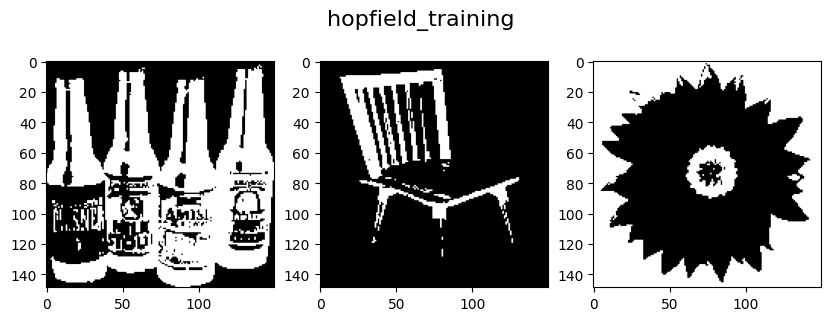

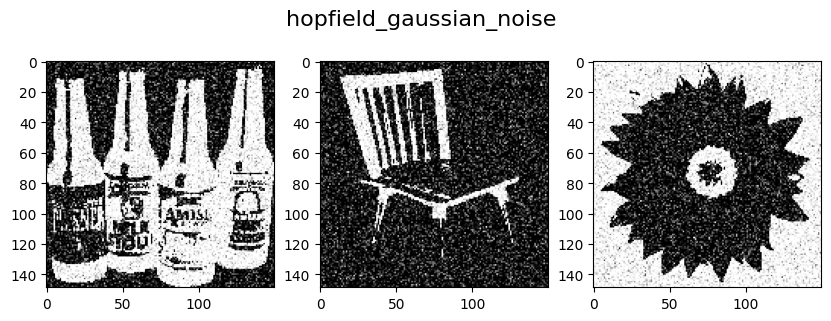

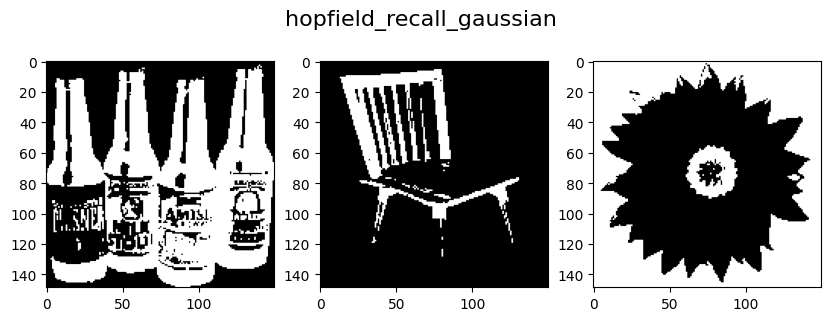

In [ ]:
# Add Gaussian Noise
# Create a Patterns object with the original patterns
pat = Patterns(patterns, 7)

ntrained = 3  # Number of patterns to display

# Display original patterns
plt_patterns(pat, ntrained, 10, name="hopfield_training")

# Convert original patterns to vectors
pattern_vectors = convert_patterns_to_vectors(pat)

# 2. Add Gaussian Noise
gaussian_noisy_patterns = add_gaussian_noise(pat, mean=0, std=0.5)  # Adjust noise level as needed
gaussian_noisy_vectors = convert_patterns_to_vectors(gaussian_noisy_patterns)
plt_patterns(gaussian_noisy_patterns, ntrained, 10, 'hopfield_gaussian_noise')

# Fit the Hopfield Network with original patterns
net = HopfieldNetwork()
net.fit(pattern_vectors, ntrained)

# Recall from Gaussian noisy patterns
pattern_recovered_gaussian = net.recall(gaussian_noisy_vectors)
pattern_rec_gaussian = convert_vectors_to_patterns(pattern_recovered_gaussian)
plt_patterns(pattern_rec_gaussian, ntrained, 10, 'hopfield_recall_gaussian')


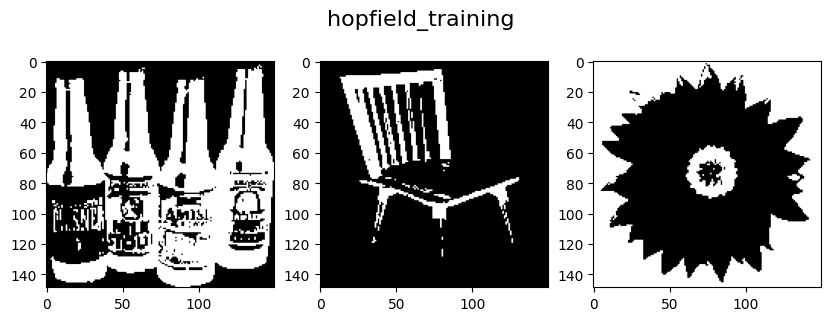

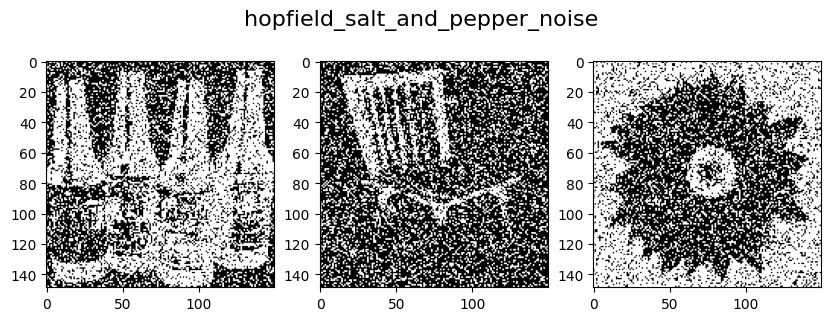

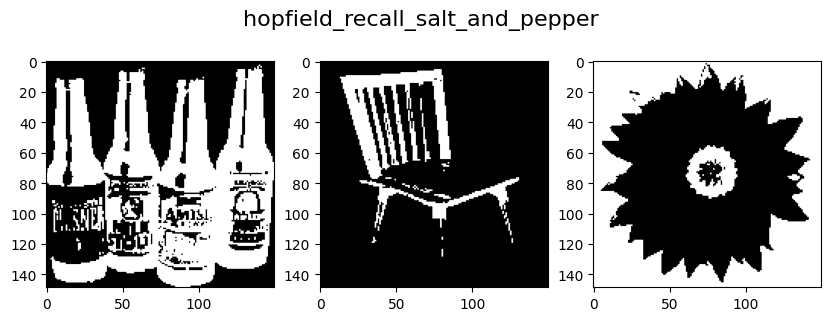

In [ ]:
# Add Salt and Pepper Noise
# Create a Patterns object with the original patterns
pat = Patterns(patterns, 7)

ntrained = 3  # Number of patterns to display

# Display original patterns
plt_patterns(pat, ntrained, 10, name="hopfield_training")

# Convert original patterns to vectors
pattern_vectors = convert_patterns_to_vectors(pat)

# 3. Add Salt and Pepper Noise
sp_noisy_patterns = add_salt_and_pepper_noise(pat, noise_rate=0.5)  # Adjust probabilities as needed
sp_noisy_vectors = convert_patterns_to_vectors(sp_noisy_patterns)
plt_patterns(sp_noisy_patterns, ntrained, 10, 'hopfield_salt_and_pepper_noise')

# Fit the Hopfield Network with original patterns
net = HopfieldNetwork()
net.fit(pattern_vectors, ntrained)

# Recall from salt and pepper noisy patterns
pattern_recovered_sp = net.recall(sp_noisy_vectors)
pattern_rec_sp = convert_vectors_to_patterns(pattern_recovered_sp)
plt_patterns(pattern_rec_sp, ntrained, 10, 'hopfield_recall_salt_and_pepper')
